In [ ]:
import numpy as np
from platform import python_version
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn.functional as F
import torch.utils.data as data_utils

Checking Python and PyTorch versions

In [ ]:
python_version()

'3.7.15'

In [ ]:
torch. __version__

'1.12.1+cu113'

We can use GPU resources

In [ ]:
torch.cuda.is_available()

True

Some global variables

In [ ]:
num_classes = 10
batch_size = 1024
num_epochs = 10      
device = 'cuda' # we can use 'cpu' for Exercise 2

Functions for training and testing models + visualizing metrics

In [ ]:
def train(model, trainloader, optimizer, loss_function):
    train_epoch_loss = 0.0
    train_epoch_correct = 0
    steps = 0  # track how many training iterations we've been through
    model.train()  # sets model to training mode
    for data, targets in trainloader:
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        # model returns the logits with shape (batch_size, num_classes)
        logits = model(data)

        loss = loss_function(logits, targets)
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()
        _, preds = torch.max(logits.data, 1)
        train_epoch_correct += (preds == targets).sum().item()
        steps += 1

    epoch_loss = train_epoch_loss / steps
    epoch_acc = 100. * (train_epoch_correct / len(trainloader.dataset))

    return epoch_loss, epoch_acc


def test(model, testloader, loss_function):
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_epoch_loss = 0.0
    test_epoch_correct = 0
    steps = 0
    with torch.no_grad():     # This ensures that the gradients are not calculated
        for data, targets in testloader:
            steps += 1
            
            data = data.to(device)
            targets = targets.to(device)
            # forward pass
            outputs = model(data)
            # calculate the loss
            loss = loss_function(outputs, targets)
            test_epoch_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            test_epoch_correct += (preds == targets).sum().item()
        
    epoch_loss = test_epoch_loss / steps
    epoch_acc = 100. * (test_epoch_correct / len(testloader.dataset))

    return epoch_loss, epoch_acc


def train_and_eval(model, trainloader, testloader, optimizer, loss_function, n_epochs):
    acc_train, acc_test, loss_train, loss_test = [], [], [], []
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}")

        tr_l, tr_acc = train(model, trainloader, optimizer, loss_function)
        tst_l, tst_acc = test(model, testloader, loss_function)

        acc_train.append(tr_acc)
        acc_test.append(tst_acc)
        loss_train.append(tr_l)
        loss_test.append(tst_l)
        print(f"Training loss: {tr_l:.3f}, test loss: {tst_l:.3f}")
        print(f"Training accuracy: {tr_acc:.3f}, test accuracy: {tst_acc:.3f}")
        print('.'*50)     
    return acc_train, acc_test, loss_train, loss_test


def plot_metrics(a_train, a_test, l_train, l_test):
    plt.figure(figsize=(7, 5))
    plt.plot(a_train, color='purple', label='Train loss')
    plt.plot(a_test, color='orange', label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(l_train, color='purple', label='Train accuracy')
    plt.plot(l_test, color='orange', label='Test accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

###Exercise 1: CNN Implementation###

We have to resize our images to 32x32 so after all convolutional layers we will get 1x1x512 Tensor as an input for fully connected part.

In [ ]:
transform = T.Compose([       
    T.Resize((32, 32)),
    T.ToTensor()                        # ToTensor() normalizes the original [0, 255] range to [0, 1]
])
train_dataset = MNIST(root='./data', transform=transform, download=True, train=True)
test_dataset = MNIST(root='./data', transform=transform, download=True, train=False)

In [ ]:
# choosing only 10000 train datapoints from 60000
# train_dataset = data_utils.Subset(train_dataset, torch.arange(10000))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Implementing a VGG11 network architecture. 

For all convolutional layers we set padding to 1 and stride is 1 by default, and after each layer we use batch normalization. num_features in BatchNorm2d is a number of output channels from previous conv layer.

For Max Pooling layers, kernel size and stride are set to 2.

In [ ]:
class VGG11(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 10, activation_f = nn.ReLU(), dropout = True):
        super(VGG11, self).__init__()
        # number of channels in the input image
        self.in_channels = in_channels
        # defines the output classes in the dataset
        self.num_classes = num_classes

        # convolutional layers 
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = 64),
            activation_f,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            activation_f,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            activation_f,
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            activation_f,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            activation_f,
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            activation_f,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            activation_f,
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            activation_f,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # fully connected layers
        if dropout:
            self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=4096),
            activation_f,
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            activation_f,
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes)
            )
        else:
            self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=4096),
            activation_f,
            nn.Linear(in_features=4096, out_features=4096),
            activation_f,
            nn.Linear(in_features=4096, out_features=self.num_classes)
            )

    def forward(self, x):
        x = self.conv_layers(x)
        print(x.size)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

For MNIST dataset, number of channels is 1 as all the images are in a grayscale format.

Our first model is VGG11 with SGD optimizer and CrossEntropyLoss and ReLU activation after each layer.

In [ ]:
# instantiating VGG11
model1 = VGG11().to(device)

# cross-entropy loss function
loss_f = nn.CrossEntropyLoss()
# SGD optimizer
opt_sgd = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)

In [ ]:
acc_train1, acc_test1, loss_train1, loss_test1 = train_and_eval(model1, train_loader, test_loader, opt_sgd, loss_f, num_epochs)

Epoch 1
Training loss: 0.542, test loss: 0.087
Training accuracy: 84.570, test accuracy: 97.240
..................................................
Epoch 2
Training loss: 0.035, test loss: 0.037
Training accuracy: 98.937, test accuracy: 98.720
..................................................
Epoch 3
Training loss: 0.018, test loss: 0.027
Training accuracy: 99.515, test accuracy: 99.050
..................................................
Epoch 4
Training loss: 0.009, test loss: 0.021
Training accuracy: 99.762, test accuracy: 99.230
..................................................
Epoch 5
Training loss: 0.004, test loss: 0.023
Training accuracy: 99.905, test accuracy: 99.280
..................................................
Epoch 6
Training loss: 0.002, test loss: 0.024
Training accuracy: 99.980, test accuracy: 99.320
..................................................
Epoch 7
Training loss: 0.001, test loss: 0.021
Training accuracy: 99.977, test accuracy: 99.350
......................

We can see that there is a slight overfitting as convergence was very fast, and the results are very good - test accuracy is more than 99%.

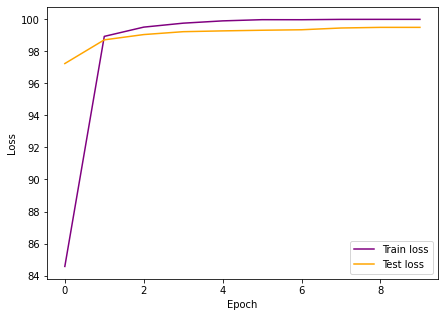

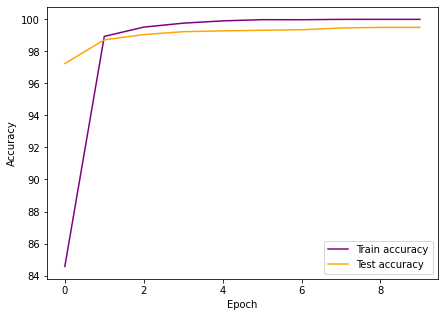

In [ ]:
plot_metrics(acc_train1, acc_test1, loss_train1, loss_test1)

Let's inspect the generalization properties of the model. We will flip the test set images and apply Gaussian blur

In [ ]:
hor_tr = T.Compose([       
    T.Resize((32, 32)),
    T.RandomHorizontalFlip(p=1),
    T.ToTensor()          
])
ver_tr = T.Compose([       
    T.Resize((32, 32)),
    T.RandomHorizontalFlip(p=1),
    T.ToTensor()          
])
blur_tr = T.Compose([       
    T.Resize((32, 32)),
    T.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
    T.ToTensor()          
])

test_h_flip = MNIST(root='./data', download=True, transform=hor_tr, train=False)
test_v_flip = MNIST(root='./data', download=True, transform=ver_tr, train=False)
test_blur = MNIST(root='./data', download=True, transform=blur_tr, train=False)

test_h_flip_loader = torch.utils.data.DataLoader(test_h_flip, batch_size=batch_size, shuffle=True)
test_v_flip_loader = torch.utils.data.DataLoader(test_v_flip, batch_size=batch_size, shuffle=True)
test_blur_loader = torch.utils.data.DataLoader(test_blur, batch_size=batch_size, shuffle=True)

Example of a flipped image

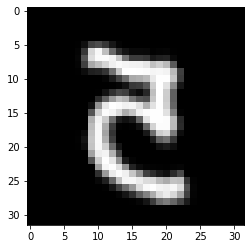

In [ ]:
images, _ = next(iter(test_v_flip_loader))
plt.imshow(images[2].reshape((32,32)), cmap="gray")

We can see that our neural network can recognize images which are flipped or blurred

In [ ]:
_, acc = test(model1, test_loader, loss_f)
print("Recalling an accuracy for initial data:", acc)

_, acc = test(model1, test_h_flip_loader, loss_f)
print("Accuracy for horizontally flipped data:", acc)

_, acc = test(model1, test_v_flip_loader, loss_f)
print("Accuracy for vertically flipped data:", acc)

_, acc = test(model1, test_blur_loader, loss_f)
print("Accuracy for blurred data:", acc)

Recalling an accuracy for initial data: 99.5
Accuracy for horizontally flipped data: 99.5
Accuracy for vertically flipped data: 99.5
Accuracy for blurred data: 99.5


Our second model is VGG11 with Adam optimizer and ReLU activation.

The hyper-parameters β1 and β2 ("betas") of Adam are initial decay rates used when estimating the first and second moments of the gradient, which are multiplied by themselves (exponentially) at the end of each training step (batch). By default, betas are set to high values: (0.9,0.999).

In [ ]:
model2 = VGG11().to(device)

loss_f = nn.CrossEntropyLoss()
# Adam optimizer
opt_adam = torch.optim.Adam(model2.parameters(), lr=0.001, betas=(0.9,0.999))

In [ ]:
acc_train2, acc_test2, loss_train2, loss_test2 = train_and_eval(model2, train_loader, test_loader, opt_adam, loss_f, num_epochs)

Epoch 1
Training loss: 1.753, test loss: 3.070
Training accuracy: 34.382, test accuracy: 30.980
..................................................
Epoch 2
Training loss: 0.372, test loss: 0.206
Training accuracy: 88.212, test accuracy: 93.350
..................................................
Epoch 3
Training loss: 0.100, test loss: 0.116
Training accuracy: 97.203, test accuracy: 96.500
..................................................
Epoch 4
Training loss: 0.057, test loss: 0.075
Training accuracy: 98.393, test accuracy: 97.790
..................................................
Epoch 5
Training loss: 0.041, test loss: 0.139
Training accuracy: 98.863, test accuracy: 96.290
..................................................
Epoch 6
Training loss: 0.035, test loss: 0.064
Training accuracy: 99.038, test accuracy: 98.390
..................................................
Epoch 7
Training loss: 0.030, test loss: 0.063
Training accuracy: 99.162, test accuracy: 98.470
......................

VG11 with Adam optimizer


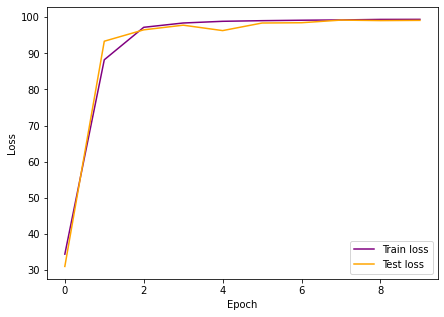

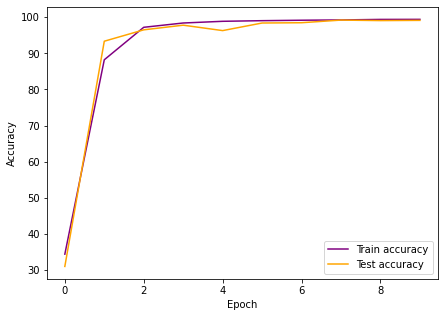

In [ ]:
print("VG11 with Adam optimizer")
plot_metrics(acc_train2, acc_test2, loss_train2, loss_test2)

Our third CNN is VGG11 with RMSprop optimizer and ReLU activation. As Adam optimizer, RMSprop is more sensitive to hyperparameters, so we trained a few times with different alphas and lerning rates to find the optimizer that converges fast.

In [ ]:
model3 = VGG11().to(device)

loss_f = nn.CrossEntropyLoss()
# RMSprop optimizer
opt_rms = torch.optim.RMSprop(model3.parameters(), lr=0.001, alpha=0.8)

acc_train3, acc_test3, loss_train3, loss_test3 = train_and_eval(model3, train_loader, test_loader, opt_rms, loss_f, num_epochs)

Epoch 1
Training loss: 2.351, test loss: 3.444
Training accuracy: 20.648, test accuracy: 12.830
..................................................
Epoch 2
Training loss: 1.250, test loss: 2.051
Training accuracy: 48.633, test accuracy: 63.040
..................................................
Epoch 3
Training loss: 0.599, test loss: 0.223
Training accuracy: 81.285, test accuracy: 91.630
..................................................
Epoch 4
Training loss: 0.299, test loss: 0.071
Training accuracy: 92.662, test accuracy: 97.850
..................................................
Epoch 5
Training loss: 0.132, test loss: 0.216
Training accuracy: 96.752, test accuracy: 94.770
..................................................
Epoch 6
Training loss: 0.109, test loss: 0.097
Training accuracy: 97.358, test accuracy: 97.600
..................................................
Epoch 7
Training loss: 0.077, test loss: 0.897
Training accuracy: 98.113, test accuracy: 82.400
......................

We can clearly see that with RMSprop we could use even more epochs as it does not overfit as much as the one with SGD.

VG11 with RMSprop optimizer


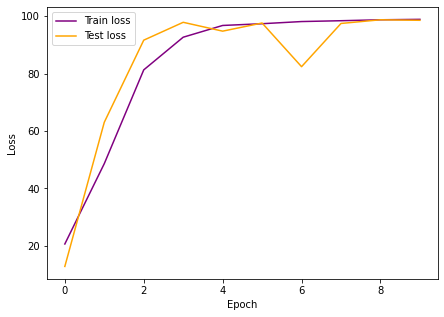

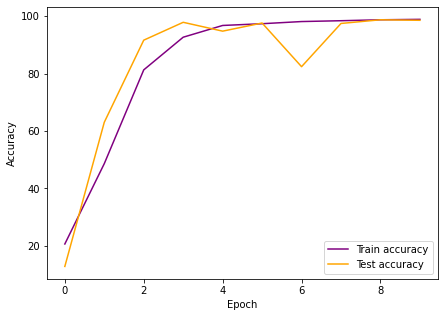

In [ ]:
print("VG11 with RMSprop optimizer")
plot_metrics(acc_train3, acc_test3, loss_train3, loss_test3)

Now let's train CNN VGG11 with Sigmoid activation. We can see that in this case we don't get convergence and model is poor - sigmoid function tends to vanish gradient, which might have happened in our case. In previous models we used ReLU, which is more computationally efficient to compute than sigmoid since it just needs to pick max(0,x) and not perform expensive exponential operations. In practice, networks with ReLU tend to show better convergence.

In [ ]:
model4 = VGG11(activation_f = nn.Sigmoid()).to(device)

loss_f = nn.CrossEntropyLoss()
opt_sgd = torch.optim.SGD(model4.parameters(), lr=0.001, momentum=0.9)

acc_train4, acc_test4, loss_train4, loss_test4 = train_and_eval(model4, train_loader, test_loader, opt_sgd, loss_f, num_epochs)

Epoch 1
Training loss: 2.345, test loss: 2.303
Training accuracy: 10.467, test accuracy: 11.350
..................................................
Epoch 2
Training loss: 2.340, test loss: 2.304
Training accuracy: 10.217, test accuracy: 11.350
..................................................
Epoch 3
Training loss: 2.339, test loss: 2.305
Training accuracy: 10.508, test accuracy: 11.350
..................................................
Epoch 4
Training loss: 2.337, test loss: 2.305
Training accuracy: 10.327, test accuracy: 11.350
..................................................
Epoch 5
Training loss: 2.335, test loss: 2.303
Training accuracy: 10.483, test accuracy: 11.350
..................................................
Epoch 6
Training loss: 2.335, test loss: 2.301
Training accuracy: 10.118, test accuracy: 11.350
..................................................
Epoch 7
Training loss: 2.336, test loss: 2.300
Training accuracy: 9.968, test accuracy: 11.350
.......................

VG11 with SGD optimizer and Sigmoid activation


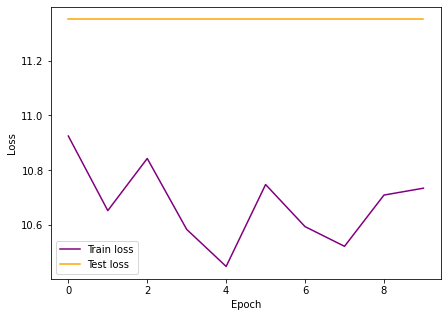

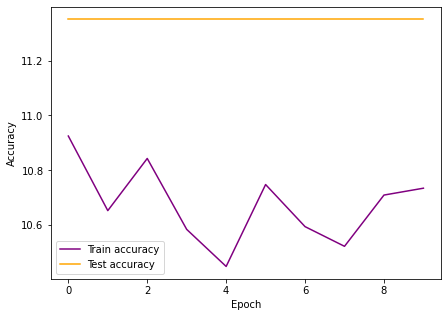

In [ ]:
print("VG11 with SGD optimizer and Sigmoid activation")
plot_metrics(acc_train4, acc_test4, loss_train4, loss_test4)

After removing Dropout from VGG11, it did not give much worse test accuracy within 10 epochs- it simply can be explained by the fact that our dataset is not complicated or big, so additional regularization via dropout was not crucial for MNIST classificator.

In [ ]:
model5 = VGG11(dropout = False).to(device)

loss_f = nn.CrossEntropyLoss()
opt_sgd = torch.optim.SGD(model5.parameters(), lr=0.01, momentum=0.9)

acc_train5, acc_test5, loss_train5, loss_test5 = train_and_eval(model5, train_loader, test_loader, opt_sgd, loss_f, num_epochs)

Epoch 1
Training loss: 0.466, test loss: 0.312
Training accuracy: 88.860, test accuracy: 90.570
..................................................
Epoch 2
Training loss: 0.030, test loss: 0.029
Training accuracy: 99.095, test accuracy: 99.040
..................................................
Epoch 3
Training loss: 0.013, test loss: 0.020
Training accuracy: 99.660, test accuracy: 99.350
..................................................
Epoch 4
Training loss: 0.005, test loss: 0.020
Training accuracy: 99.908, test accuracy: 99.280
..................................................
Epoch 5
Training loss: 0.002, test loss: 0.020
Training accuracy: 99.982, test accuracy: 99.350
..................................................
Epoch 6
Training loss: 0.001, test loss: 0.019
Training accuracy: 99.998, test accuracy: 99.380
..................................................
Epoch 7
Training loss: 0.001, test loss: 0.018
Training accuracy: 100.000, test accuracy: 99.400
.....................

VG11 without dropout


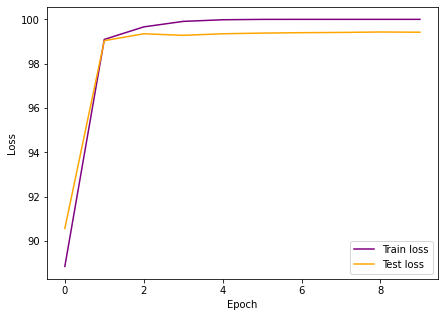

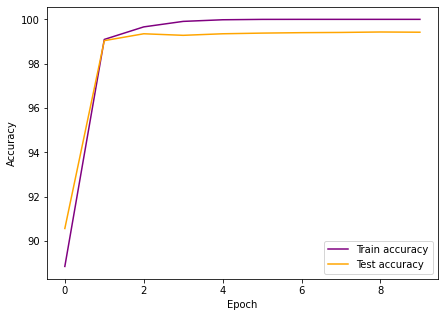

In [ ]:
print("VG11 without dropout")
plot_metrics(acc_train5, acc_test5, loss_train5, loss_test5)

###Exercise 2: MLP Implementation###

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_classes = 10):
        super(MLP, self).__init__()
        # defines the output classes in the dataset
        self.num_classes = num_classes

        self.layers = nn.Sequential(
            nn.Linear(in_features=784, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.num_classes)
        )
    def forward(self, x):
        # flattening
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

In [ ]:
transform = T.Compose([       
    T.Resize((28, 28)),
    T.ToTensor()
])
train_dataset = MNIST(root='./data', transform=transform, download=True, train=True)
test_dataset = MNIST(root='./data', transform=transform, download=True, train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training time for VGG11 (using GPU power) was the same as MLP's, but MLP required more epochs to get a good metric on test dataset. Therefore, we can conclude that MNIST dataset does not require a neural network of high complexity, it would be enough to add additional layers to MLP if one would like to have less number of epochs for training and a bit higher metric.

In [ ]:
model6 = MLP().to(device)

loss_f = nn.CrossEntropyLoss()
opt_sgd = torch.optim.SGD(model6.parameters(), lr=0.01, momentum=0.9)

num_epochs = 20
acc_train6, acc_test6, loss_train6, loss_test6 = train_and_eval(model6, train_loader, test_loader, opt_sgd, loss_f, num_epochs)

Epoch 1
Training loss: 0.595, test loss: 0.275
Training accuracy: 83.018, test accuracy: 92.980
..................................................
Epoch 2
Training loss: 0.215, test loss: 0.179
Training accuracy: 93.922, test accuracy: 95.000
..................................................
Epoch 3
Training loss: 0.156, test loss: 0.141
Training accuracy: 95.727, test accuracy: 95.890
..................................................
Epoch 4
Training loss: 0.122, test loss: 0.120
Training accuracy: 96.673, test accuracy: 96.530
..................................................
Epoch 5
Training loss: 0.099, test loss: 0.103
Training accuracy: 97.405, test accuracy: 96.900
..................................................
Epoch 6
Training loss: 0.082, test loss: 0.093
Training accuracy: 97.865, test accuracy: 97.280
..................................................
Epoch 7
Training loss: 0.069, test loss: 0.087
Training accuracy: 98.268, test accuracy: 97.490
......................

MLP classificator


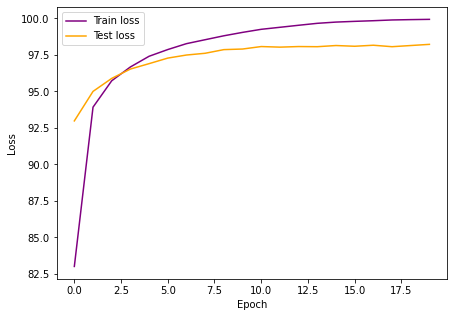

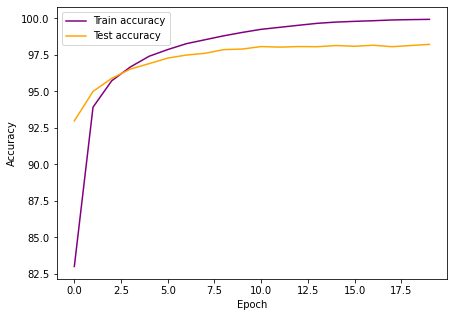

In [ ]:
print("MLP classificator")
plot_metrics(acc_train6, acc_test6, loss_train6, loss_test6)